In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import DataFrameSet
from utils import *
import pandas as pd
from pathlib import Path

setting = 'fuji'

Available workers: 8


In [3]:
files = get_files(DATA_DIR)
df = pd.DataFrame(files, columns=['filename'])
tmp = df.filename.apply(lambda x: extract_filename_info(str(x), setting=setting))
df = pd.DataFrame.from_records(tmp, columns=dataframe_columns)

dfs = DataFrameSet(df)

(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=150x150 at 0x7FAB4045ED90>, 'v(cy)', '/media/kalfasyan/HGST_4TB/Datasets/pbox_vs_fuji/fuji/v(cy)/2019_kampen_w32_AA_17_F10_51 mm_ISO160_1-15 s_3daysold_134.jpg', 47603)


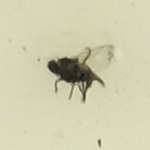

In [44]:
n=47603
print(dfs[n])
dfs[n][0]

In [46]:
dfs.df.iloc[n]

filename     /media/kalfasyan/HGST_4TB/Datasets/pbox_vs_fuj...
label                                                    v(cy)
name         2019_kampen_w32_AA_17_F10_51 mm_ISO160_1-15 s_...
year                                                      2019
location                                            kampenhout
date                                                       w32
xtra                                                        AA
plate_idx                                                  134
Name: 47603, dtype: object

In [47]:
df.name.iloc[0]

'2020_Herent_w28_3-30_F10_51 mm_ISO160_1-15 s_IncandescentWB_111'